# 照片 -> 情感 -> 推荐音乐

基本的操作全是复用 recommend-text.ipynb 里面的代码，只是最后从的推荐从

- 文本 => emotext => recommend

改成:

- 图片 => emopic => recommend

In [1]:
# load config

import json

with open('config.json') as f:
    config = json.load(f)

In [2]:
# init db

from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base

engine = create_engine(config['db'])

Base = automap_base()
Base.prepare(engine, reflect=True)

Track = Base.classes.tracks
Comment = Base.classes.comments
TrackEmotion = Base.classes.track_emotions

session = Session(engine)

In [3]:
# emotion vector

from typing import List
from collections import namedtuple

import emotext

Emotion = namedtuple('Emotion', emotext.emotions)


def keys(self):
    return self._fields


def values(self):
    return tuple(self)


Emotion.keys = keys
Emotion.values = values


def emotion_vector(emotions: List[TrackEmotion]) -> Emotion:
    elems = dict.fromkeys(emotext.emotions, 0)
    elems.update({x.emotion: x.intensity for x in emotions})
    ev = Emotion(**elems)

    return ev

NEW: load model

下面这一步有点新了，不训练模型了，recommend-text.ipynb 里面已经有训练、保存好了。
这里直接取一个模型出来用就行了。

In [4]:
# NEW: load model

import json
import joblib


def load_data_model(data_file, model_file):
    with open(data_file) as df:
        d = json.load(df)
    m = joblib.load(model_file)
    return d, m


data, nbrs = load_data_model('savedata/7597.json', 'savemodels/7597.joblib')

NEW: recommend from picture

类似于 recommend-text.ipynb 的 recommend_from_text，
只是改成输入图片。

In [5]:
from emopic.emotic2emotext import emotic2dlut

import requests

EMOPIC_SERVER = 'http://localhost:8080/infer'


def emotion_from_pic(imgpath: str) -> Emotion:
    """从图片中获取情感。

    请求 emopic/emotic 的 EMOPIC_SERVER 服务，获取给定图片的情感。
    会考虑图片中所有人物 (bbox from yolo)，以图片中人物所占面积比为权重，加权平均。

    :param imgpath: 图片路径
    :return: Emotion 对象
    """
    resp = requests.post(EMOPIC_SERVER, files={
        'img': (imgpath, open(imgpath, 'rb')),
    })
    # [{
    #   "bbox": [65, 15, 190, 186],
    #   "cat": {"Excitement": 0.16, "Peace": 0.11},
    #   "cont": [5.97, 6.06, 7.23]
    # }]
    emotic_result = resp.json()

    # 总的情感
    total_emotion = dict.fromkeys(emotext.emotions, 0.0)

    # 人在图片中占的面积
    area = lambda bbox: (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    areas = [area(p['bbox']) for p in emotic_result]
    sum_area = sum(areas)

    # 转成 emotext 情感，面积大的人权重大
    for person, person_area in zip(emotic_result, areas):
        person_emo = emotic2dlut(person['cat'], person['cont'])
        weight = person_area / sum_area

        for emo, value in person_emo.items():
            total_emotion[emo] += value * weight

    sum_v = sum(v for v in total_emotion.values())
    for k in total_emotion:
        total_emotion[k] /= sum_v

    return Emotion(**total_emotion)


def recommend_from_pic(imgpath: str):
    """给图片，算情感，找近邻，作推荐

    :param imgpath: 推荐种子图片
    :return: (emotion, distances, tracks): 计算得到的 text 情感，和推荐结果：距离与曲目
    """

    # get emotion
    e = emotion_from_pic(imgpath)

    # recommend
    distances, indices = nbrs.kneighbors([e], 10)

    # result tracks
    tracks = []
    for i in range(len(indices[0])):
        idx = indices[0][i]
        tid = data['ids'][idx]
        t = session.query(Track).where(Track.id == tid)[0]
        tracks.append(t)

    return e, distances, tracks


def print_nbrs(distances, tracks):
    for d, t in zip(distances[0], tracks):
        ar = list(map(lambda a: a.name, t.artists_collection))
        print(f'dist={d:.4f}: ({t.id})\t {t.name} - {ar}')


emotion, distances, tracks = recommend_from_pic('/Users/c/Desktop/26.jpg')
print(emotion)
print_nbrs(distances, tracks)

Emotion(PA=0.10446567880160978, PE=0.0, PD=0.0, PH=0.0, PG=0.0, PB=0.0, PK=0.0, NA=0.09767218300690408, NB=0.08282885139461889, NJ=0.07548193947088512, NH=0.0, PF=0.04071860209611547, NI=0.0, NC=0.04258730894668551, NG=0.0, NE=0.11425301854517324, ND=0.0996940283143101, NN=0.17943451126697582, NK=0.0, NL=0.1259537317781286, PC=0.03691014637859337)
dist=0.1824: (36871866)	 隐形的翅膀 (Live) - ['张韶涵']
dist=0.2001: (316486)	 野孩子 - ['杨千嬅']
dist=0.2035: (451126971)	 Paris - ['Else']
dist=0.2230: (447079586)	 Look At Me! - ['XXXTENTACION']
dist=0.2280: (520460196)	 I always smile but my eyes are sad - ['asokah.']
dist=0.2294: (498371679)	 ι - ['α·Pav']
dist=0.2298: (28923455)	 路 - ['隔壁团乐队']
dist=0.2319: (26116350)	 GASSHOW - ['illion']
dist=0.2336: (740765)	 しろつめくさ - ['ハンバート ハンバート']
dist=0.2345: (30431367)	 走马 - ['陈粒']


In [6]:
emotion, distances, tracks = recommend_from_pic('/Users/c/Desktop/1.jpg')
print(emotion)
print_nbrs(distances, tracks)

Emotion(PA=0.0, PE=0.0, PD=0.0, PH=0.0, PG=0.1774100239032825, PB=0.0, PK=0.0, NA=0.0, NB=0.0, NJ=0.0, NH=0.0, PF=0.0, NI=0.0, NC=0.0, NG=0.0, NE=0.2837818768910778, ND=0.0, NN=0.0, NK=0.19931980925347687, NL=0.33948828995216274, PC=0.0)
dist=0.4097: (405599470)	 疑心病 - ['任然']
dist=0.4177: (459068807)	 天后（DJ版） - ['绪尘']
dist=0.4241: (27600462)	 Runaway Baby - ['Bruno Mars']
dist=0.4250: (473418654)	 不定 - ['苏琛']
dist=0.4273: (460043708)	 What Do I Know? - ['Ed Sheeran']
dist=0.4446: (430114655)	 Astronomia - ['Vicetone', 'Tony Igy']
dist=0.4459: (149763)	 毕业后你不是我的 - ['孙子涵']
dist=0.4463: (29414450)	 把你含在我嘴里 - ['杨青']
dist=0.4476: (26178041)	 千年の祈り - ['姫神']
dist=0.4478: (26491581)	 What Makes You Beautiful - ['One Direction']


In [7]:
emotion, distances, tracks = recommend_from_pic('/Users/c/Desktop/21.23.jpg')
print(emotion)
print_nbrs(distances, tracks)

Emotion(PA=0.0, PE=0.0, PD=0.0, PH=0.0, PG=0.04797134958618257, PB=0.0, PK=0.0, NA=0.0, NB=0.0, NJ=0.15106514434069437, NH=0.0, PF=0.0, NI=0.0, NC=0.0, NG=0.0, NE=0.1548680807942048, ND=0.2596078740967889, NN=0.21640554913127888, NK=0.0, NL=0.17008200205085047, PC=0.0)
dist=0.2441: (19934760)	 Leaves in the Wind - ['Isaac Shepard']
dist=0.2476: (418708385)	 ミチノチモシーキミノキモチ - ['森永千才']
dist=0.2580: (139703)	 我想更懂你 - ['潘玮柏', '苏芮']
dist=0.2694: (29009655)	 East of Eden - ['Zella Day']
dist=0.2740: (718551)	 比翼の羽根 - ['eufonius']
dist=0.2804: (17721274)	 Wrecking Ball - ['Frankmusik']
dist=0.2808: (477982)	 Old Memory - ['Bruno Wen-li']
dist=0.2822: (421137966)	 牵丝戏 - ['Aki阿杰', '银临', '大琴师音乐游戏']
dist=0.2863: (407889392)	 LA LA LAND (Extended Mix) - ['DVBBS', 'Shaun Frank', 'Delaney Jane']
dist=0.2890: (412175153)	 φ¹ - ['α·Pav']


🖼 img_file: /Users/c/Desktop/imgs/女士-孤独-悲伤-情绪-年轻女子-只要.jpg


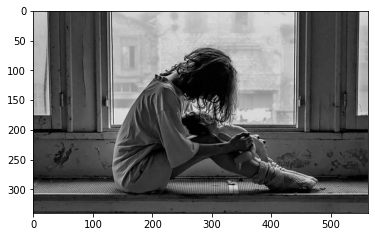

Emotion(PA=0.0, PE=0.2083971362064195, PD=0.0, PH=0.0, PG=0.0, PB=0.0, PK=0.25678204553455236, NA=0.0, NB=0.0, NJ=0.0, NH=0.0, PF=0.0, NI=0.0, NC=0.0, NG=0.0, NE=0.15316331233290595, ND=0.0, NN=0.0, NK=0.19321975438248407, NL=0.18843775154363815, PC=0.0)
dist=0.3636: (508917206)	 Lullaby  - ['Enzalla']
dist=0.3935: (34916301)	 Nuit Silencieuse - ['Days']
dist=0.3982: (29137873)	 τ - ['α·Pav']
dist=0.4030: (31356499)	 Waiting For Love - ['Avicii', 'Martin Garrix', 'Simon Aldred']
dist=0.4038: (29137874)	 ε - ['α·Pav']
dist=0.4094: (535377723)	 Zombie - ['Bad Wolves']
dist=0.4121: (420478436)	 We Don't Talk Anymore (Mr. Collipark Remix) - ['Charlie Puth', 'Selena Gomez', 'Mr. Collipark']
dist=0.4130: (543681750)	 Lemon（翻自 米津玄師）  - ['Akie秋绘']
dist=0.4146: (509276016)	 LOST MYSELF - ['TAZ']
dist=0.4175: (34766855)	 Waiting For Tremor (COOL BROS Edit) - ['Avicii', 'Daft Punk', 'Martin Garrix', 'Dimitri Vegas & Like Mike', 'COOL BROS']
🖼 img_file: /Users/c/Desktop/imgs/folklore.jpg


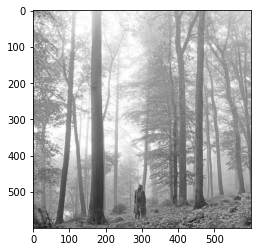

Emotion(PA=0.0, PE=0.0, PD=0.0, PH=0.0, PG=0.7708945766152239, PB=0.0, PK=0.0, NA=0.0, NB=0.0, NJ=0.0, NH=0.0, PF=0.0, NI=0.0, NC=0.0, NG=0.0, NE=0.10882563795865652, ND=0.0, NN=0.0, NK=0.0, NL=0.12027978542611956, PC=0.0)
dist=0.2721: (33705392)	 誓约 - ['卢文韬']
dist=0.3349: (375184)	 相信 - ['苏打绿']
dist=0.3590: (176403)	 我相信 - ['杨培安']
dist=0.3606: (417859121)	 一定要相信自己 - ['卢广仲']
dist=0.3768: (29747956)	 Special - ['Six60']
dist=0.3796: (60263)	 他一定很爱你 - ['阿杜']
dist=0.3909: (187564)	 左右手 - ['张国荣']
dist=0.4224: (366577)	 不值得 - ['梦飞船']
dist=0.4423: (25727424)	 值得 - ['张敬轩']
dist=0.4687: (1645108)	 Born a Stranger - ['Kan R. Gao']
🖼 img_file: /Users/c/Desktop/imgs/女孩-伤心-肖像-沮丧-独自的-压力.jpg


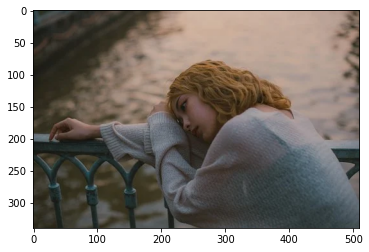

Emotion(PA=0.05415190864662392, PE=0.05452802750840649, PD=0.0, PH=0.0, PG=0.0, PB=0.059588634240930465, PK=0.0, NA=0.0, NB=0.14063880072245277, NJ=0.12763175103891844, NH=0.0, PF=0.08493050461168578, NI=0.0, NC=0.06892466628558122, NG=0.0, NE=0.07391117554677384, ND=0.12438681210480716, NN=0.08620505531336096, NK=0.0, NL=0.07290896832516763, PC=0.05219369565529137)
dist=0.2065: (28247830)	 Say Something - ['Christina Aguilera', 'A Great Big World']
dist=0.2081: (454069168)	 ты любил её ?! - ['dalebotbeats']
dist=0.2095: (26116350)	 GASSHOW - ['illion']
dist=0.2136: (27579123)	 Enemy - ['Jennifer March']
dist=0.2158: (501133798)	 Jocelyn Flores - ['XXXTENTACION']
dist=0.2164: (190062)	 记事本 - ['周传雄']
dist=0.2227: (286603)	 你不知道的事(国) - ['Robynn & Kendy']
dist=0.2269: (350127)	 你再也读不出我任何欲望 - ['Cicada']
dist=0.2279: (29544534)	 The Last String - ['Jacoo']
dist=0.2309: (208938)	 空白格 - ['蔡健雅']
🖼 img_file: /Users/c/Desktop/imgs/BADモード.jpg


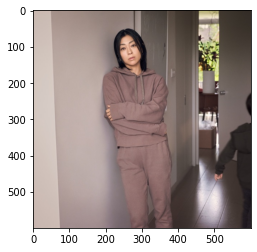

Emotion(PA=0.11028015635003333, PE=0.0, PD=0.0, PH=0.0, PG=0.0, PB=0.0, PK=0.0, NA=0.0, NB=0.0, NJ=0.23044607269298015, NH=0.0, PF=0.18020732808670925, NI=0.0, NC=0.0, NG=0.0, NE=0.15795958874091603, ND=0.06908036153628606, NN=0.05511026532954258, NK=0.0, NL=0.1969162272635327, PC=0.0)
dist=0.3171: (31645164)	 癌 - ['华晨宇']
dist=0.3246: (34040698)	 被风吹过的夏天 - ['林俊杰', '金莎']
dist=0.3257: (190249)	 趁早(2005版) - ['张宇']
dist=0.3343: (31514961)	 百年不合 - ['周柏豪']
dist=0.3373: (503819010)	 做我女朋友 - ['吴海啸', '扬科YANGK']
dist=0.3390: (454955323)	 时间杀人事件 - ['安全着陆']
dist=0.3439: (25642484)	 好心分手 - ['王力宏', '卢巧音']
dist=0.3441: (190062)	 记事本 - ['周传雄']
dist=0.3453: (103892)	 情难枕 - ['姜育恒']
dist=0.3494: (525278524)	 无问 - ['毛不易']
🖼 img_file: /Users/c/Desktop/imgs/evermore.jpg


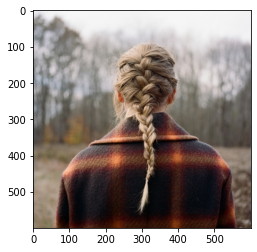

Emotion(PA=0.18721293808298747, PE=0.1157311839210211, PD=0.06976669118989957, PH=0.16487635215369661, PG=0.0, PB=0.2217401601709907, PK=0.0, NA=0.0, NB=0.12362294286391834, NJ=0.0, NH=0.11704973161748618, PF=0.0, NI=0.0, NC=0.0, NG=0.0, NE=0.0, ND=0.0, NN=0.0, NK=0.0, NL=0.0, PC=0.0)
dist=0.1760: (77237)	 驼铃 - ['刀郎']
dist=0.1774: (31134621)	 《瞬间的永恒》夜色钢琴曲 - ['赵海洋']
dist=0.1849: (26609650)	 等我先说 - ['夏天Alex']
dist=0.1852: (28936510)	 星星 - ['牛奶咖啡']
dist=0.1864: (65312)	 明年今日 (2007 Live) - ['陈奕迅']
dist=0.1904: (424995410)	 Homage - ['Mild High Club']
dist=0.1906: (31365604)	 你从未离去 - ['白挺']
dist=0.1920: (108578)	 不流泪的机场 - ['林俊杰']
dist=0.1930: (522320784)	 Ich bin Himmel, wenn ich den Himmel liebe (feat. Seraphina Theresa) - ['Sergio Díaz De Rojas']
dist=0.1932: (478507889)	 卡农（经典钢琴版） - ['dylanf']
🖼 img_file: /Users/c/Desktop/imgs/担心的女孩-女士-等待-坐着-思维-担心.jpg


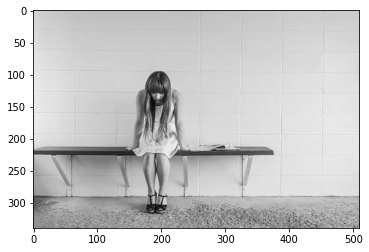

Emotion(PA=0.0, PE=0.4330946858462544, PD=0.0, PH=0.0, PG=0.0, PB=0.0, PK=0.0, NA=0.0, NB=0.0, NJ=0.0, NH=0.0, PF=0.0, NI=0.0, NC=0.0, NG=0.0, NE=0.2509110587946572, ND=0.0, NN=0.0, NK=0.0, NL=0.31599425535908837, PC=0.0)
dist=0.4073: (167882)	 清明雨上 - ['许嵩']
dist=0.4184: (385965)	 知足 - ['五月天']
dist=0.4324: (483378330)	 巫堵 - ['deca joins']
dist=0.4336: (474739467)	 心安理得 - ['王天戈']
dist=0.4552: (25642144)	 另一个天堂 - ['王力宏', '张靓颖']
dist=0.4554: (462391069)	 长生诀 - ['西瓜JUN']
dist=0.4556: (376971)	 樱花草 - ['Sweety']
dist=0.4590: (388068)	 青苹果乐园 - ['小虎队']
dist=0.4676: (610830)	 梦のしずく - ['松たか子']
dist=0.4679: (151200)	 天堂 - ['腾格尔']
🖼 img_file: /Users/c/Desktop/imgs/man-woman-dog-pet-pug.jpg


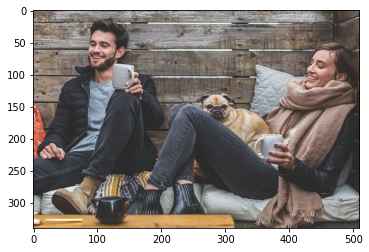

Emotion(PA=0.0, PE=0.24263436759360654, PD=0.0, PH=0.0, PG=0.2534350516875478, PB=0.0, PK=0.0, NA=0.0, NB=0.0, NJ=0.0, NH=0.0, PF=0.0, NI=0.0, NC=0.0, NG=0.0, NE=0.13432194703968986, ND=0.0, NN=0.0, NK=0.19016556010554395, NL=0.17944307357361183, PC=0.0)
dist=0.3744: (31356499)	 Waiting For Love - ['Avicii', 'Martin Garrix', 'Simon Aldred']
dist=0.3825: (404184492)	 I'll Be Waiting... - ['Pearl']
dist=0.3833: (108277)	 自然醒 - ['林宥嘉']
dist=0.3844: (459068807)	 天后（DJ版） - ['绪尘']
dist=0.3876: (426881480)	 夢灯籠 - ['RADWIMPS']
dist=0.3906: (2313544)	 Axel F - ['Crazy Frog']
dist=0.3915: (1486496)	 Hedwig's Theme - ['John Williams']
dist=0.3989: (186331)	 最冷一天 - ['陈奕迅']
dist=0.4032: (509276016)	 LOST MYSELF - ['TAZ']
dist=0.4055: (34766855)	 Waiting For Tremor (COOL BROS Edit) - ['Avicii', 'Daft Punk', 'Martin Garrix', 'Dimitri Vegas & Like Mike', 'COOL BROS']
🖼 img_file: /Users/c/Desktop/imgs/愤怒的人-观点-手指-印度-生气的-男性.jpg


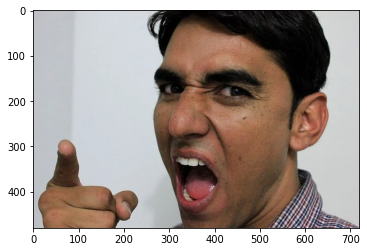

Emotion(PA=0.0, PE=0.0, PD=0.0, PH=0.0, PG=0.0, PB=0.0, PK=0.0, NA=0.1341677068127249, NB=0.11298885713776956, NJ=0.0905623360662674, NH=0.0, PF=0.0633625957481961, NI=0.08955975406625569, NC=0.043165529800919006, NG=0.03031220199771567, NE=0.0699924173359102, ND=0.13264031372450502, NN=0.10594707409697865, NK=0.015039193383703813, NL=0.07564090958173572, PC=0.03662111024731822)
dist=0.2508: (28586064)	 I'm Not the Only One - ['Sam Smith']
dist=0.2547: (25729599)	 月光奏鸣曲第一乐章 - ['Ludwig van Beethoven']
dist=0.2637: (740765)	 しろつめくさ - ['ハンバート ハンバート']
dist=0.2652: (36871866)	 隐形的翅膀 (Live) - ['张韶涵']
dist=0.2682: (350127)	 你再也读不出我任何欲望 - ['Cicada']
dist=0.2699: (454069168)	 ты любил её ?! - ['dalebotbeats']
dist=0.2706: (26116350)	 GASSHOW - ['illion']
dist=0.2715: (27579123)	 Enemy - ['Jennifer March']
dist=0.2723: (501133798)	 Jocelyn Flores - ['XXXTENTACION']
dist=0.2821: (19945735)	 Demons - ['Imagine Dragons']
🖼 img_file: /Users/c/Desktop/imgs/男人-时尚-快乐的-人们-微笑-太阳镜.jpg


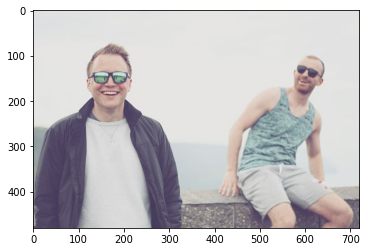

Emotion(PA=0.20909870694390195, PE=0.16449240872243676, PD=0.07056223907953148, PH=0.0, PG=0.0, PB=0.23441432613109905, PK=0.0, NA=0.0, NB=0.0, NJ=0.0, NH=0.05715488755195668, PF=0.0, NI=0.0, NC=0.0, NG=0.0, NE=0.11180368195966135, ND=0.0, NN=0.0, NK=0.049581873781198445, NL=0.10289187583021427, PC=0.0)
dist=0.2255: (1369959)	 Rue des trois frères - ['Fabrizio Paterlini']
dist=0.2362: (5268324)	 Dance of Gossamer - ['Music therapy']
dist=0.2450: (4064275)	 A Song For The Morning Star - ['Endless Melancholy']
dist=0.2467: (25643093)	 大城小爱(Live) - ['王力宏']
dist=0.2553: (479713267)	 一个人的星空 - ['马路通']
dist=0.2583: (535093555)	 水星上的鲸 - ['hui sonata']
dist=0.2583: (280765)	 喜欢两个人 - ['彭佳慧']
dist=0.2587: (30612793)	 多远都要在一起 - ['G.E.M.邓紫棋']
dist=0.2589: (516929058)	 久违 - ['Swang多雷']
dist=0.2596: (239188)	 没那么简单 - ['黄小琥']
🖼 img_file: /Users/c/Desktop/imgs/people-father-daughter.jpg


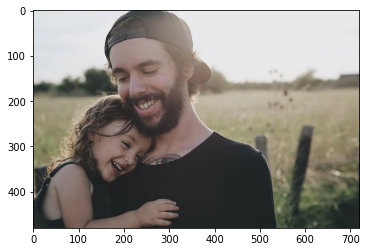

Emotion(PA=0.20584727734653888, PE=0.027586217833704973, PD=0.07414345928730189, PH=0.1421536722095688, PG=0.0, PB=0.20448521158989658, PK=0.0, NA=0.0, NB=0.0, NJ=0.0, NH=0.09175455368924752, PF=0.0, NI=0.0, NC=0.0, NG=0.0, NE=0.0464917649119337, ND=0.0, NN=0.077386691461585, NK=0.0, NL=0.04808860635586506, PC=0.08206254531435767)
dist=0.1547: (27978505)	 Come Back Down - ['Mediks']
dist=0.1583: (472050059)	 You're Gonna Live Forever in Me - ['John Mayer']
dist=0.1615: (316100)	 雨爱 - ['杨丞琳']
dist=0.1649: (21965211)	 You're Gonna Go Far, Kid - ['The Offspring']
dist=0.1665: (489410556)	 Ed Sheeran / J.Fla - Shape of You (Mashup) - ['ɴᴏᴛʜɪɴɢ.']
dist=0.1684: (31421442)	 アイロニ - ['majiko']
dist=0.1690: (471986831)	 The World Is Asleep - ['Svanur']
dist=0.1742: (26620638)	 Letter - ['iris']
dist=0.1746: (108260)	 握不住的他 - ['林俊杰']
dist=0.1750: (32648305)	 Maps (双声道) - ['Maroon 5']
🖼 img_file: /Users/c/Desktop/imgs/男人-老的-高级-苦难-绝望-头痛.jpg


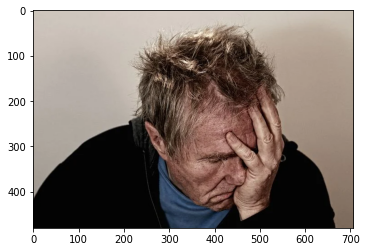

Emotion(PA=0.02524475604640978, PE=0.0, PD=0.0, PH=0.0, PG=0.0, PB=0.0, PK=0.0, NA=0.14119622951027788, NB=0.10618949370933503, NJ=0.08584671334896102, NH=0.0, PF=0.051010179838376246, NI=0.08786783668666606, NC=0.04683108987784619, NG=0.036459748562864776, NE=0.06944745995680128, ND=0.1303721418471499, NN=0.11305506803905996, NK=0.0, NL=0.0697136813301895, PC=0.036765601246062395)
dist=0.2422: (28586064)	 I'm Not the Only One - ['Sam Smith']
dist=0.2532: (36871866)	 隐形的翅膀 (Live) - ['张韶涵']
dist=0.2547: (25729599)	 月光奏鸣曲第一乐章 - ['Ludwig van Beethoven']
dist=0.2574: (740765)	 しろつめくさ - ['ハンバート ハンバート']
dist=0.2604: (26116350)	 GASSHOW - ['illion']
dist=0.2695: (350127)	 你再也读不出我任何欲望 - ['Cicada']
dist=0.2720: (454069168)	 ты любил её ?! - ['dalebotbeats']
dist=0.2728: (316486)	 野孩子 - ['杨千嬅']
dist=0.2744: (27579123)	 Enemy - ['Jennifer March']
dist=0.2757: (501133798)	 Jocelyn Flores - ['XXXTENTACION']


In [9]:
import os
import matplotlib.pyplot as plt

def _img_recommend(img_file):
    print(f'🖼 img_file: {img_file}')
    im = plt.imread(img_file)
    plt.imshow(im)
    plt.show()

    emotion, distances, tracks = recommend_from_pic(img_file)
    print(emotion)
    print_nbrs(distances, tracks)

for root, dirs, files in os.walk('/Users/c/Desktop/imgs/'):
    for file in files:
        if not file.endswith('jpg'):
            continue
        img = os.path.join(root, file)
        _img_recommend(img)